# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


# **Maestría en Inteligencia Artificial Aplicada**
## **Subject: Advance Machine Learning Methods**
### Tecnológico de Monterrey
### Jose Antonio Cantoral Ceballos

## Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

**Names and IDs of team members:**

|Nombre|Matrícula|
|:---|:---|
| Rodrigo López Aguilera | A01793071 |
| Diego Carrera Nicholls | A00464290 |
| Zmaltzin Paola Godinez Juarez | A01793548 |
| Ruben Guerrero del Fierro | A01793005 |

We make the necessary imports which in this case they aren't so many since the Neural Network (NN) was made only using numpy as its backbone for the whole operations.

In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

We load the path of our dataset and see the head of the dataframe to check the information stored.

In [2]:
DATA_PATH = './asl_data/'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Define labels and data

We now define which values will be the 'y' and 'x' data. It's important to note that we need this information to be as numpy arrays for the training of the NN.

In [4]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
x_val.shape

(7172, 784)

This function will be useful later on as it will split our dataset given a given percentage specified in the parameters, furthermore it can shuffle our samples if we specified it as well.

In [6]:
# Function split the validation set into validation and test
def split_val_test(x, y, pct=0.5, shuffle=True):
  '''
  Create a function that will allow you to split the previously loaded set
  into validation and test set.
  '''
  total_samples = x.shape[0]

  # Shuffle the dataset
  if shuffle == True:
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

  # Calculate the sizes of the validation and test sets
  valid_size = int(total_samples * pct)
  test_size = int(total_samples * pct)

  # Split the dataset
  x_val = x[indices[:valid_size]]
  y_val = y[indices[:valid_size]]

  x_test = x[indices[valid_size:valid_size+test_size]]
  y_test = y[indices[valid_size:valid_size+test_size]]

  return x_val, y_val, x_test, y_test

In [7]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [8]:
x_val.shape

(3586, 784)

This step is to remove those classes which we don't have samples of, trying to train the neural network without these samples could lead to some issues in accuracy.

In [9]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalization

This function will provide us with a way to normalize our pictures, the reason we want to do this is to basically have all values in all of our features with a mean of zero and a standard deviation of 1 or very close to it. It improves accuracy, it makes the data easier to manipulate and ensures uniformity across all data.

In [10]:
def normalise(x_mean, x_std, x_data):
    """
    Normalise the data by subtracting the mean and dividing by the standard deviation.
    x_mean: mean of the data
    x_std: standard deviation of the data
    x_data: data to be normalised
    """
    return (x_data - x_mean) / x_std

In [11]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [12]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Plot some pictures

In [13]:
def plot_number(image):
    """
    Plot the image of a letter.
    """
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

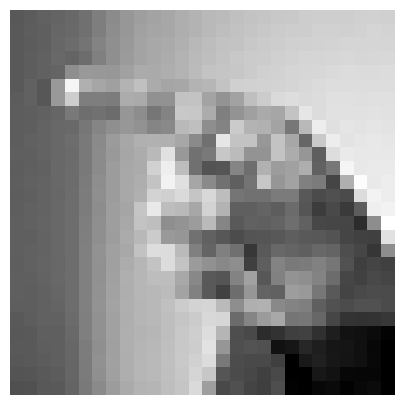

In [14]:
rnd_idx = np.random.randint(x_val.shape[0])
random_image = x_val[rnd_idx].reshape((28,28))
plot_number(random_image)

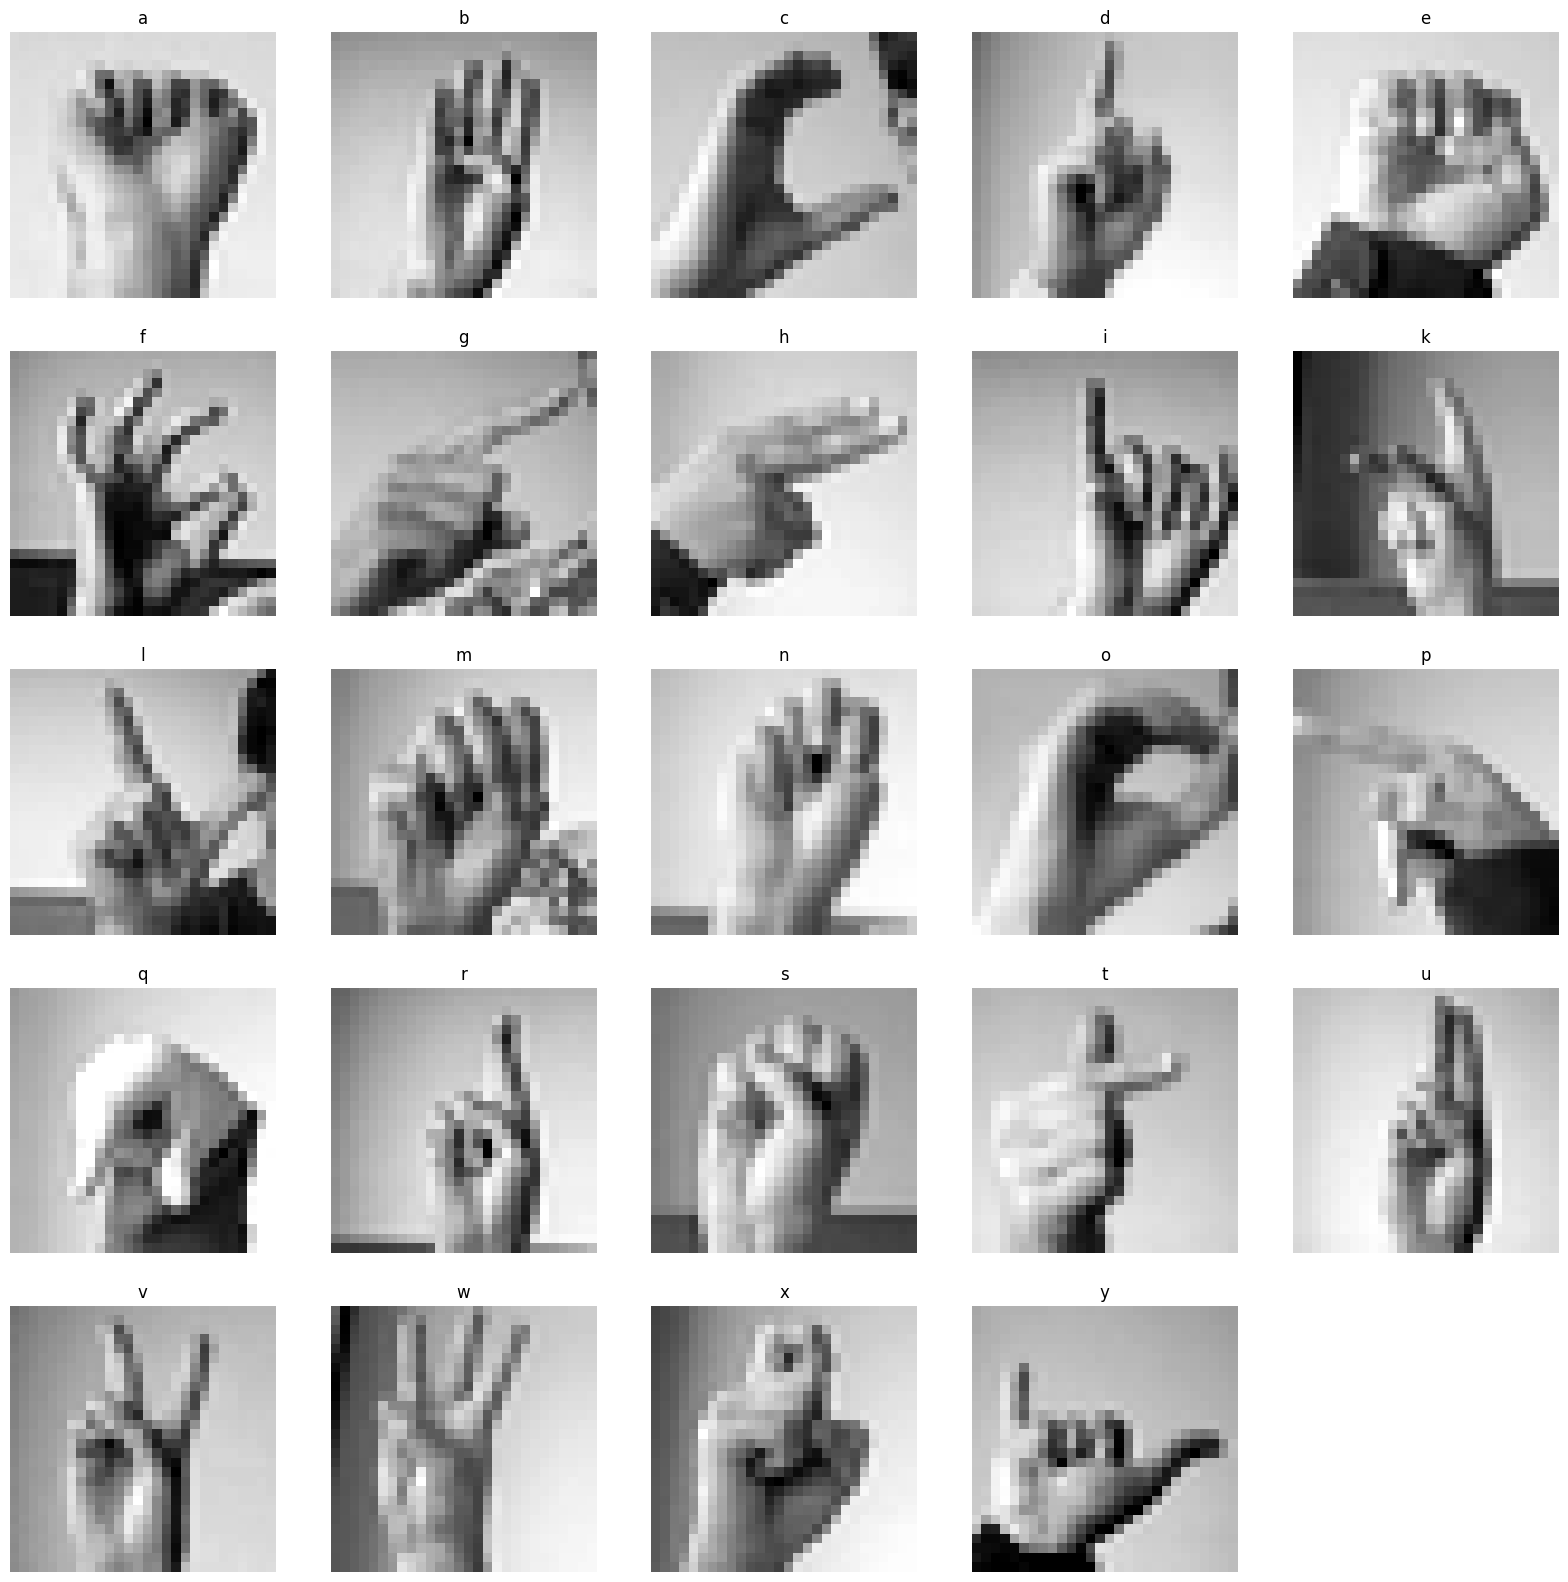

In [27]:
# plot all the letters in the alphabet

plt.figure(figsize=(20, 20))
for i in range(len(alphabet)):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[y_train == i][0].reshape(28, 28), cmap='gray')
    plt.title(f'{alphabet[i]}')
    plt.axis('off')

### Equations for our model


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

#### Mini batches

This function will be useful when training our NN since it will create batches of a given size specified in the parameters which then can be used for gradient descent. There are several flavors for gradient descent but the choice for this activity was to use mini-batch gradient descent. Some advantages for this algorithm are that the model update frequency is higher than batch gradient descent which allows for a more robust convergence, avoiding local minima, the batched updates provide a computationally more efficient process than stochastic gradient descent and the batching allows both the efficiency of not having all training data in memory and algorithm implementations.

In [15]:
def create_minibatches(mb_size, x, y, shuffle = True):
  """
  Create minibatches of the data for the training process.
  size: size of the minibatches
  x: data
  y: labels
  shuffle: shuffle the data before creating the minibatches
  """
  assert x.shape[0] == y.shape[0]
  total_data = x.shape[0]
  if shuffle:
    idxs = np.arange(total_data)
    np.random.shuffle(idxs)
    x = x[idxs]
    y = y[idxs]
  return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Linear, ReLU and Sequential classes

This is just a definition of our 'tensor' which its inherited from the numpy array functionality but it will serve as the backbone for our classes to create the arquitecture of the NN.

In [16]:
class np_tensor(np.ndarray): pass

The following classes represent the different kind of neurons that we will be able to put together to form a NN, the first two: Linear and ReLU represent linear and Rectified Linear Unit (ReLU) activation functions of a neuron. They both have a backward method to compute the gradients through backpropagation and a call method which represents the respective activation functions. The only difference is the Linear class which has an intialization of the $W$ gradients to be calculated, this of course depends on the input size for the neurons and the output size of the next layer.

Finally there's the Sequential class which represents a sequential stack of neural network layers, it takes a list of layers and applies them sequentially. Then it basically calls the backward method from the neurons to start the backpropagation and the calculation of the gradients and then it updates them. Finally a predict method to have final prediction after the gradients have been computed.

###  Linear class

In [17]:
class Linear():
    """
    Class for a linear layer
    """
    def __init__(self, input_size, output_size):
        """
        Init layer using Kaiming He initialization.
        input_size: number of input neurons
        output_size: number of output neurons
        """
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X):
        """
        Forward pass, dot product of weights and input plus bias.
        X: input data    
        """
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        """
        Backward pass.
        x: input data
        grad: gradient from the previous layer
        """
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)

### ReLU class

In [18]:
class ReLU():
    """
    Class for a ReLU activation layer
    """
    def __call__(self, Z):
        """
        Forward pass.
        Z: input data
        """
        return np.maximum(0, Z)
    def backward(self, Z, A):
        """
        Backward pass.
        Z: input data
        A: output of the forward pass
        """
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Sequential class

In [19]:
class Sequential_layers():
    """
    layers - lista que contiene objetos de tipo Linear, ReLU
    """
    def __init__(self, layers):
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

The cost function is called 'softmaxXEntropy' and is the one used for this kind of classification problems where the classification is shown as an array of probabilities with the index of the highest probability being the actual classification. This cost function will be one of the references when training the NN to know if the gradients are actually giving a better or worse accuracy through each iteration.

In [20]:
def softmaxXEntropy(x, y):
    """
    Softmax and cross entropy loss.
    x: input data
    y: labels
    """
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### Training

We now define two more functions which will train our NN model through the use of our mini batches function explained earlier and the cost function. The next function is the accuracy which as it name implies will calculate the accuracy of the prediction of our NN and the actual prediction in the dataset.

In [21]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    """
    Train the model.
    model: model to be trained
    epochs: number of epochs
    mb_size: minibatch size
    learning_rate: learning rate for the update
    """
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [22]:
def accuracy(x, y, mb_size):
    """
    Calculate the accuracy of the model.
    x: data
    y: labels
    mb_size: minibatch size  
    """
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

### Model

For the architecture we chose for this solution, we use the same one as the one that was used for the MNIST dataset in the example notebook. After some experimentation we found that the this is the closest accuracy we can get, about 77%-78%. Any other parameters we can control, the batch size, the learning rate and the epochs don't seem to really affect the performance or accuracy of the NN. And so, this is the final architecture used:
- A layer of 200 neurons
- Followed by a ReLU activation
- Next another layer of 200 neurons
- Followed by a ReLU activation
- And finally a final layer of 24 neurons for the classification of the image

In [23]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 24)])
mb_size = 128
learning_rate = 1e-4
epochs = 20

In [24]:
train(model, epochs, mb_size, learning_rate)

costo: 1.0160536866150751, accuracy: 0.5764082543223648
costo: 0.5038538151355975, accuracy: 0.658393753485778
costo: 0.3184578794379762, accuracy: 0.7124930284439487
costo: 0.19215779076719425, accuracy: 0.7281093139988846
costo: 0.1270418462564838, accuracy: 0.7479085331846068
costo: 0.11631252965998896, accuracy: 0.7437255995538204
costo: 0.06768714685231643, accuracy: 0.7518126045733408
costo: 0.05515562763533645, accuracy: 0.7590630228667038
costo: 0.05336209394542723, accuracy: 0.7593418851087562
costo: 0.040912178360058594, accuracy: 0.7610150585610709
costo: 0.03597773901563671, accuracy: 0.7598996095928612
costo: 0.03520654537240386, accuracy: 0.7638036809815951
costo: 0.028852967598317503, accuracy: 0.7654768544339097
costo: 0.02384158922678162, accuracy: 0.7679866146123815
costo: 0.02666597909961843, accuracy: 0.7643614054657
costo: 0.018054774439666955, accuracy: 0.769659788064696
costo: 0.01673477991044178, accuracy: 0.7707752370329057
costo: 0.016579711659327347, accuracy

We can see the accuracy for our model was about 77%.

In [25]:
print(accuracy(x_test, y_test, mb_size))

0.7704963747908533


### Test your model on Random data from your test set

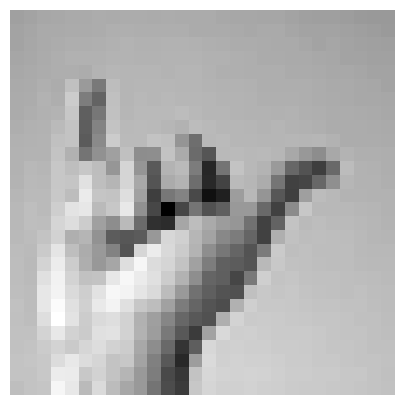

el valor predicho es: y el valor real es:y


In [26]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')

## Final comments

We can see how actual NN works behind the scenes of all those libraries specialized in using these types of models. The only caveat on using just numpy is we can't actually get any better unless we implement other techniques for improving the gradient descent algorithm. In this case, since there was no optimizer like Adam or Adaline we can't be certain that our best accuracy with the given architecture was actually that value or if it can reach even higher. Nevertheless, a very interesting activity.